# **Autoencoder Model - Anomaly Detection**
### Group 8

### **__Comments__**

- **Model without finetuning**

- Model was a basic autoencoder architecture (could be tuned further)

- Evaluation methods need to be explored further

- Batch size was chosen as 64 because of it being the standard should be changed

- We need to create the (normalized) score values for the 

In [1]:
# Libraries
from util import *

# Random state/seed
random_state = 42

In [2]:
features = open("Data/features.json")
data_dict=json.load(features)

In [3]:
data_dict=time_diff(data_dict)

In [4]:
l_lon=[]
l_lat=[]
l_time=[]
l_time_diff=[]
l_inst=[]
l_url=[]
l_response=[]
l_weight=[]
for i in data_dict.keys():
    for log in data_dict[i]:
        l_lat.append(log["coords"][0])
        l_lon.append(log["coords"][1])
        l_time.append(log["log_time"])
        l_time_diff.append(log["time_diff"])
        l_inst.append(log["instruction"])
        l_url.append(log["url"])
        l_response.append(log["response"])
        l_weight.append(log["response_weight"])

In [5]:
for i in range(len(l_time)):
    l_time[i]=l_time[i][0]

In [6]:
l_lat=pd.Series(l_lat)
l_lon=pd.Series(l_lon)
l_time=pd.Series(l_time)
l_inst=pd.Series(l_inst)
l_url=pd.Series(l_url)
l_response=pd.Series(l_response)
l_weight=pd.Series(l_weight)


# Example of data
print(l_lat[0]) # 22.3193
print(l_lon[0]) # 40.7128
print(l_time[0]) # 18
print(l_inst[0]) # HEAD
print(l_url[0]) # /fr/que-faire/que-fer-sitges-de-nit.htm HTTP/2.0
print(l_response[0]) # 200
print(l_weight[0]) # 9037


print(l_lat.dtype) # float64
print(l_lon.dtype) # float64
print(l_time.dtype) # int64
print(l_inst.dtype) # object
print(l_url.dtype) # object
print(l_response.dtype) # object
print(l_weight.dtype) # object

22.3193
114.169
6
HEAD
/fr/pag492/explora-platges-i-ports-2/id12/les-anquines.htm HTTP/1.1
301
4840
float64
float64
int64
object
object
object
object


In [7]:
# Convert l_weight to numeric dtype
l_weight = pd.to_numeric(l_weight)

# Create a DataFrame
frame = {
    "Lat": l_lat,
    "Lon": l_lon,
    "Time": l_time,
    "Time Diff": l_time_diff,
    "Instruction": l_inst,
    "URL": l_url,
    "Response": l_response,
    "Weight": l_weight
}
data = pd.DataFrame(frame)

In [8]:
data

,Lat,Lon,Time,Time Diff,Instruction,URL,Response,Weight
0,22.3193,114.1690,6,-1,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840
1,22.3193,114.1690,6,1,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5223
2,22.3193,114.1690,6,5,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,4840
3,22.3193,114.1690,6,1,HEAD,/fr/pag492/explora-platges-i-ports-2/id12/les-...,200,5260
4,22.3193,114.1690,6,1,GET,/fr/pag492/explora-platges-i-ports-2/id12/les-...,301,661
...,...,...,...,...,...,...,...,...
1077388,33.2749,-111.8870,2,1,GET,/media/site1/cache/images/port-aiguadolc-1.jpg...,200,278950
1077389,52.3667,4.9000,11,-1,GET,/nl/pl330/nieuws/kalender/id1113/he-mort-el-po...,404,7423
1077390,52.3667,4.9000,11,27,GET,/nl/pl330/nieuws/kalender/id1113/he-mort-el-po...,404,2815
1077391,39.5638,-0.3368,11,-1,GET,/media/site1/cache/images/dji-0077-2-redim-enc...,200,227390


**Model Pipeline & Split**

In [9]:
# Convert relevant columns to float
data["Time"] = data["Time"].astype(float)
data["Weight"] = data["Weight"].astype(float)
data["Time Diff"] = data["Time Diff"].astype(float)
data["Lat"] = data["Lat"].astype(float)
data["Lon"] = data["Lon"].astype(float)

In [10]:
# Normalizing features using z-score normalization
scaler_lat = StandardScaler()
scaler_lon = StandardScaler()
scaler_time = StandardScaler()
scaler_weight = StandardScaler()

lat = scaler_lat.fit_transform(np.array(data["Lat"]).reshape(-1, 1))
lon = scaler_lon.fit_transform(np.array(data["Lon"]).reshape(-1, 1))
time = scaler_time.fit_transform(np.array(data["Time"]).reshape(-1, 1))
weight = scaler_weight.fit_transform(np.array(data["Weight"]).reshape(-1, 1))

In [11]:
#One Hot Encoding of Instruction and Response, since they are categorical features that consist of only one part
one_hot_instruction=OneHotEncoder(handle_unknown='ignore')
one_hot_response=OneHotEncoder(handle_unknown='ignore')
encoded_instruction=one_hot_instruction.fit_transform(np.array(frame["Instruction"]).reshape(-1, 1)).toarray()
encoded_response=one_hot_response.fit_transform(np.array(frame["Response"]).reshape(-1, 1)).toarray()

In [12]:
encoded_time_diff=encode_time_diff(frame["Time Diff"])

In [13]:
# Cargar el DataFrame desde el archivo CSV
df=pd.read_csv('Data/url_vectors.csv')

# Extraer los vectores de las demás columnas
encoded_urls_tensor=df.iloc[:,:].values  # Todas las demás columnas son los componentes del vector

In [14]:
class CustomDataset(Dataset):
    def __init__(self, lat, lon, time, weight, encoded_time_diff,encoded_urls_tensor,encoded_instruction,encoded_response):
        self.lat = torch.tensor(lat, dtype=torch.float32)
        self.lon = torch.tensor(lon, dtype=torch.float32)
        self.time = torch.tensor(time, dtype=torch.float32)
        self.weight = torch.tensor(weight, dtype=torch.float32)

        self.features_combined = torch.cat((self.lat,self.lon,self.time,self.weight),dim =1)
        self.encoded_time_diff = torch.tensor(encoded_time_diff, dtype=torch.float32)
        self.encoded_urls_tensor = torch.tensor(encoded_urls_tensor, dtype=torch.float32)
        self.encoded_instruction = torch.tensor(encoded_instruction, dtype=torch.float32)
        self.encoded_response = torch.tensor(encoded_response, dtype=torch.float32)

    def __len__(self):
        return self.lat.shape[0]

    def __getitem__(self, idx):
        return self.features_combined[idx], self.encoded_time_diff[idx], self.encoded_urls_tensor[idx], self.encoded_instruction[idx], self.encoded_response[idx]


# Split the dataset into training and validation sets
dataset = CustomDataset(lat, lon, time, weight, encoded_time_diff,encoded_urls_tensor,encoded_instruction,encoded_response)

In [15]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset,batch_size=512)
test_loader = DataLoader(test_dataset,batch_size=512)

In [16]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.proj_combined = nn.Linear(4,40)
        self.proj_instruction = nn.Linear(6,10)
        self.proj_response = nn.Linear(11,10)
        self.proj_timediff = nn.Linear(5,10)
        self.proj_word_embedding = nn.Linear(30,10)
        
        self.encoder = nn.Sequential(
            nn.Linear(80, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 80),
            nn.Sigmoid()
        )


    def forward(self, x):
        combined, timediff, url, instruction, response = x 
        combined = self.proj_combined(combined)
        timediff = self.proj_timediff(timediff)
        url = self.proj_word_embedding(url)
        instruction = self.proj_instruction(instruction)
        response = self.proj_response(response)

        res = torch.cat((combined,timediff,url,instruction,response),dim=1)

        encoded = self.encoder(res)
        decoded = self.decoder(encoded)
        
        return res, decoded

In [17]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

autoencoder=Autoencoder().to(device)

# Define loss function and optimizer
criterion=nn.MSELoss()
optimizer=optim.Adam(autoencoder.parameters(), lr=0.001)

In [18]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for idx, data in enumerate(train_loader):
        # Move data to the device
        data = [d.to(device) for d in data]
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        input, output = autoencoder(data)
        
        # Compute the loss
        loss = criterion(output, input)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if(idx%400==0):
            print(f"Epoch; {epoch}, batch: {idx}, loss: {loss.item()}")


    # Print loss for this epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

print("Training complete.")

Epoch; 0, batch: 0, loss: 0.47741833329200745
Epoch; 0, batch: 400, loss: 0.010367394424974918
Epoch; 0, batch: 800, loss: 0.00098795082885772
Epoch; 0, batch: 1200, loss: 0.00010393070988357067
Epoch; 0, batch: 1600, loss: 0.0009613371221348643
Epoch [1/10], Loss: 0.0336
Epoch; 1, batch: 0, loss: 5.0760736485244706e-05
Epoch; 1, batch: 400, loss: 1.5145703400776256e-05
Epoch; 1, batch: 800, loss: 1.2998289093957283e-05
Epoch; 1, batch: 1200, loss: 4.914089913654607e-06
Epoch; 1, batch: 1600, loss: 4.809991878573783e-06
Epoch [2/10], Loss: 0.0003
Epoch; 2, batch: 0, loss: 3.8851530916872434e-06
Epoch; 2, batch: 400, loss: 2.107782620441867e-06
Epoch; 2, batch: 800, loss: 2.02156070372439e-06
Epoch; 2, batch: 1200, loss: 1.0490564363863086e-06
Epoch; 2, batch: 1600, loss: 1.984054051717976e-06
Epoch [3/10], Loss: 0.0000
Epoch; 3, batch: 0, loss: 7.762354243823211e-07
Epoch; 3, batch: 400, loss: 7.749156907266297e-07
Epoch; 3, batch: 800, loss: 7.53995834656962e-07
Epoch; 3, batch: 1200,

In [19]:
torch.save(autoencoder.state_dict(), 'autoencoder.pth')

torch.save(autoencoder, 'autoencoder_entire.pth') # Entire model

In [20]:
# Initialize test loss and list to store reconstruction errors
train_loss = 0.0
reconstruction_errors_train = []
criterion_by_individual=nn.MSELoss(reduction='none')

with torch.no_grad():
    for data in train_loader:
        # Convert data (list of tensors) to a single tensor
        data = [d.to(device) for d in data]
        
        # Forward pass
        input, reconstructions = autoencoder(data)
        
        # Compute loss
        loss = criterion(reconstructions, input)

        loss_individuals=criterion_by_individual(reconstructions, input)

        loss_individuals=loss_individuals.mean(dim=1)
        
        # Accumulate the total test loss
        train_loss += loss.item()
        
        # Store reconstruction errors
        reconstruction_errors_train.extend(loss_individuals.cpu().numpy())

# Calculate average test loss
avg_train_loss = train_loss / len(test_loader)

# Convert reconstruction errors list to a tensor
reconstruction_errors = torch.tensor(reconstruction_errors_train)

# Calculate mean and standard deviation of reconstruction errors
mean_error_train = torch.mean(reconstruction_errors)
std_error_train = torch.std(reconstruction_errors)

k=2
anomaly_mark=mean_error_train+k*std_error_train

reconstruction_errors_train=[(x.item()/anomaly_mark) for x in reconstruction_errors]

print(f"Average Train Loss: {avg_train_loss}")

Average Train Loss: 1.1844472205590248e-06


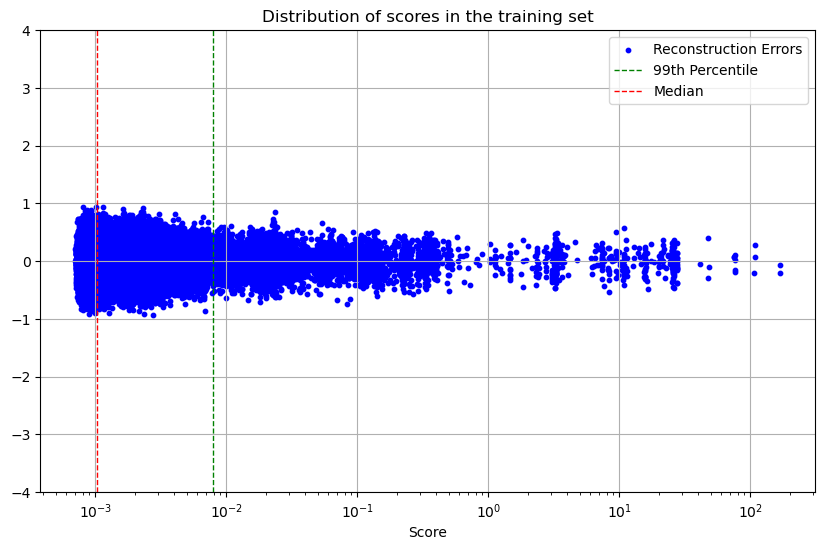

In [21]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.ylim(-4, 4)
jitter=0.2*np.random.randn(np.array(reconstruction_errors_train).size)
plt.scatter(reconstruction_errors_train, jitter, color='blue',s=10, label='Reconstruction Errors')
plt.axvline(np.percentile(reconstruction_errors_train, 99), color='green', linestyle='dashed', linewidth=1, label='99th Percentile')
plt.axvline(np.percentile(reconstruction_errors_train, 50), color='red', linestyle='dashed', linewidth=1, label='Median')
plt.xlabel('Score')
plt.title('Distribution of scores in the training set')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Initialize test loss and list to store reconstruction errors
test_loss = 0.0
reconstruction_errors = []

with torch.no_grad():
    for data in test_loader:
        # Convert data (list of tensors) to a single tensor
        data = [d.to(device) for d in data]
        
        # Forward pass
        input, reconstructions = autoencoder(data)
        
        # Compute loss
        loss = criterion(reconstructions, input)

        loss_individuals=criterion_by_individual(reconstructions, input)

        loss_individuals=loss_individuals.mean(dim=1)
        
        # Accumulate the total test loss
        test_loss += loss.item()
        
        # Store reconstruction errors
        reconstruction_errors.extend(loss_individuals.cpu().numpy())

# Calculate average test loss
avg_test_loss = test_loss / len(test_loader)

print(f"Average Test Loss: {avg_test_loss}")

Average Test Loss: 2.7097052824093286e-07


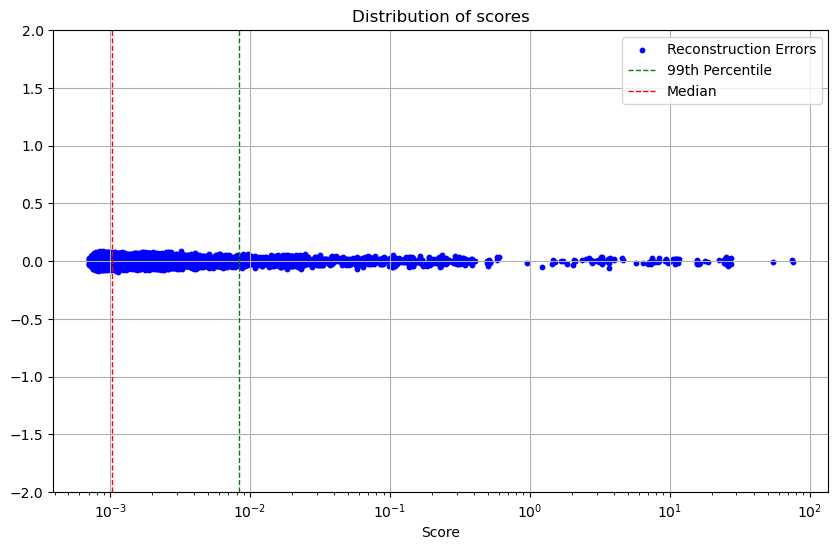

In [23]:
reconstruction_errors_test=[(x/anomaly_mark) for x in reconstruction_errors]

plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.ylim(-2, 2)
jitter=0.02*np.random.randn(np.array(reconstruction_errors_test).size)
plt.scatter(reconstruction_errors_test, jitter, color='blue',s=10, label='Reconstruction Errors')
plt.axvline(np.percentile(reconstruction_errors_test, 99), color='green', linestyle='dashed', linewidth=1, label='99th Percentile')
plt.axvline(np.percentile(reconstruction_errors_test, 50), color='red', linestyle='dashed', linewidth=1, label='Median')
plt.xlabel('Score')
plt.title('Distribution of scores')
plt.legend()
plt.grid(True)
plt.show()

# Inference

In [24]:
model=api.load('fasttext-wiki-news-subwords-300')

In [25]:
data_inference, log_list=data_inference_extraction(path="Logs\Inference.log")
data_inference

,IP,Lat,Lon,Time,Time Diff,Instruction,URL,Response,Weight
0,50.37.219.130,44.8885,-116.0742,16,-1,GET,/plantilles/turisme/css/menu-screen.css?v=5 HT...,200,1926
1,50.37.219.130,44.8885,-116.0742,16,0,GET,/comu/js/jquery.browser.js HTTP/2.0,200,1453
2,50.37.219.130,44.8885,-116.0742,16,0,GET,/comu/fancybox/helpers/jquery.fancybox-media.j...,200,2033
3,50.37.219.130,44.8885,-116.0742,16,0,GET,/comu/fancybox/helpers/jquery.fancybox-thumbs....,200,1535
4,50.37.219.130,44.8885,-116.0742,16,0,GET,/comu/js/jquery.hoverIntent.minified.js HTTP/2.0,200,1001
...,...,...,...,...,...,...,...,...,...
2495,79.152.142.72,41.3705,2.1627,0,0,GET,/comu/js/lib.js?v=3 HTTP/2.0,200,11214
2496,79.152.142.72,41.3705,2.1627,0,0,GET,/comu/fancybox/jquery.fancybox.old.js HTTP/2.0,200,13959
2497,79.152.142.72,41.3705,2.1627,0,0,GET,/comu/js/jquery.hoverIntent.minified.js HTTP/2.0,200,1001
2498,79.152.142.72,41.3705,2.1627,0,0,GET,/comu/fancybox/helpers/jquery.fancybox-thumbs....,200,1535


In [26]:
l_url=data_inference['URL'].tolist()
res=[]
for element in l_url:
    try:
        res.append(url_to_vector(element,model))
    except:
        res.append(np.zeros(30))

In [27]:
# Convert relevant columns to float
data_inference["Time"]=data_inference["Time"].astype(float)
data_inference["Weight"]=data_inference["Weight"].astype(float)
data_inference["Time Diff"]=data_inference["Time Diff"].astype(float)
data_inference["Lat"]=data_inference["Lat"].astype(float)
data_inference["Lon"]=data_inference["Lon"].astype(float)

In [28]:
lat=scaler_lat.transform(np.array(data_inference["Lat"]).reshape(-1, 1))
lon=scaler_lon.transform(np.array(data_inference["Lon"]).reshape(-1, 1))
time=scaler_time.transform(np.array(data_inference["Time"]).reshape(-1, 1))
weight=scaler_weight.transform(np.array(data_inference["Weight"]).reshape(-1, 1))

In [29]:
encoded_instruction=one_hot_instruction.transform(np.array(data_inference["Instruction"]).reshape(-1, 1)).toarray()
encoded_response=one_hot_response.transform(np.array(data_inference["Response"]).reshape(-1, 1)).toarray()

In [30]:
dataset=CustomDataset(lat, lon, time, weight, encoded_time_diff, encoded_urls_tensor, encoded_instruction, encoded_response)

inference_loader=DataLoader(dataset, batch_size=2500, shuffle=False)

In [31]:
reconstruction_errors_inference=[]
for data in inference_loader:
    data=[d.to(device) for d in data]
    
    input, reconstructions=autoencoder(data)

    loss_individuals=criterion_by_individual(reconstructions, input)

    loss_individuals=loss_individuals.mean(dim=1)
    
    # Store reconstruction errors
    reconstruction_errors_inference.extend(loss_individuals.cpu().detach().numpy())


reconstruction_errors_inference=[(x.item()/anomaly_mark) for x in reconstruction_errors_inference]

error_by_log_list=[]
for ip, error in zip(log_list, reconstruction_errors_inference):
    error_by_log_list.append((ip, error.item()))

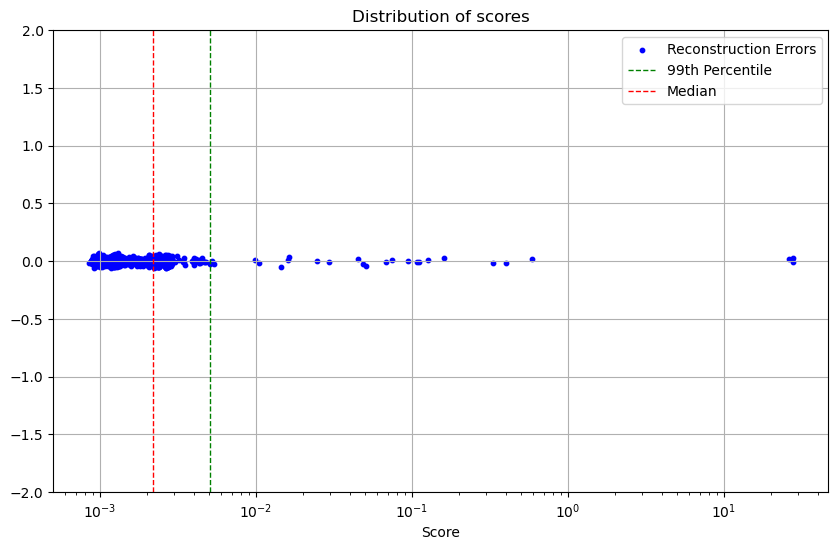

In [32]:
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.ylim(-2, 2)
jitter=0.02*np.random.randn(np.array(reconstruction_errors_inference).size)
plt.scatter(reconstruction_errors_inference, jitter, color='blue',s=10, label='Reconstruction Errors')
plt.axvline(np.percentile(reconstruction_errors_inference, 99), color='green', linestyle='dashed', linewidth=1, label='99th Percentile')
plt.axvline(np.percentile(reconstruction_errors_inference, 50), color='red', linestyle='dashed', linewidth=1, label='Median')
plt.xlabel('Score')
plt.title('Distribution of scores')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
def get_percentage_of_logs(error_by_log_list, p):
    number_to_return=int(len(error_by_log_list)*p)
    l=sorted(error_by_log_list, key=lambda x: x[1], reverse=True)
    return l[:number_to_return]

def get_number_of_logs(error_by_log_list, n):
    if(n>len(error_by_log_list)):
        return sorted(error_by_log_list, key=lambda x: x[1], reverse=True)
    else:
        return sorted(error_by_log_list, key=lambda x: x[1], reverse=True)[:n]

def get_sus_logs(error_by_log_list, danger):
    l=sorted(error_by_log_list, key=lambda x: x[1], reverse=True)
    l=[x for x in l if x[1]>=danger]
    return l

def extract_csv(error_by_log_list, mode="default", danger=1, p=0.1, n=100, csv_file='logs.csv'):
    if mode=="default":
        l=get_sus_logs(error_by_log_list, danger)
    elif(mode=="number"):
        l=get_number_of_logs(error_by_log_list, n)
    elif(mode=="percentage"):
        l=get_percentage_of_logs(error_by_log_list, p)
    else:
        print("That's not a mode, the modes are: default, number and percentage")
        return None

    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Log', 'Score'])
        writer.writerows(l)
    return l

In [34]:
l=extract_csv(error_by_log_list, mode="default", csv_file="logs_default.csv")

# Single Log Analyser

In [35]:
log='www.sitgesanytime.com 80.32.126.242 - - [22/Jan/2024:00:33:35 +0100] "GET /comu/fancybox/helpers/jquery.fancybox-thumbs.css?v=1.0.7 HTTP/2.0" 200 363 "https://www.sitgesanytime.com/es/explora/descubrimos-nuestro-legado/un-paseo-por-el-casco-antiguo.htm" "Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1"'

In [36]:
data_analyser, logs=data_inference_extraction(l=[log])
data_analyser

,IP,Lat,Lon,Time,Time Diff,Instruction,URL,Response,Weight
0,80.32.126.242,41.4022,2.1407,0,-1,GET,/comu/fancybox/helpers/jquery.fancybox-thumbs....,200,363


In [37]:
l_url=data_analyser['URL'].tolist()
res=[]
for element in l_url:
    try:
        res.append(url_to_vector(element, model))
    except:
        res.append(np.zeros(30))

In [38]:
# Convert relevant columns to float
data_analyser["Time"]=data_analyser["Time"].astype(float)
data_analyser["Weight"]=data_analyser["Weight"].astype(float)
data_analyser["Time Diff"]=data_analyser["Time Diff"].astype(float)
data_analyser["Lat"]=data_analyser["Lat"].astype(float)
data_analyser["Lon"]=data_analyser["Lon"].astype(float)

In [39]:
lat=scaler_lat.transform(np.array(data_analyser["Lat"]).reshape(-1, 1))
lon=scaler_lon.transform(np.array(data_analyser["Lon"]).reshape(-1, 1))
time=scaler_time.transform(np.array(data_analyser["Time"]).reshape(-1, 1))
weight=scaler_weight.transform(np.array(data_analyser["Weight"]).reshape(-1, 1))

In [40]:
encoded_instruction=one_hot_instruction.transform(np.array(data_analyser["Instruction"]).reshape(-1, 1)).toarray()
encoded_response=one_hot_response.transform(np.array(data_analyser["Response"]).reshape(-1, 1)).toarray()

In [41]:
dataset=CustomDataset(lat, lon, time, weight, encoded_time_diff, encoded_urls_tensor, encoded_instruction, encoded_response)

analyser_loader=DataLoader(dataset, batch_size=2500, shuffle=False)

In [42]:
reconstruction_errors_analyser=[]
for data in analyser_loader:
    data=[d.to(device) for d in data]
    
    input, reconstructions=autoencoder(data)

    loss_individuals=criterion_by_individual(reconstructions, input)

    loss_individuals=loss_individuals.mean(dim=1)
    
    # Store reconstruction errors
    reconstruction_errors_analyser.extend(loss_individuals.cpu().detach().numpy())


reconstruction_errors_analyser=[(x.item()/anomaly_mark) for x in reconstruction_errors_analyser]

error_by_log_list=[]
for ip, error in zip(logs, reconstruction_errors_analyser):
    error_by_log_list.append((ip, error.item()))

In [43]:
if(error_by_log_list[0][1]>1):
    print(f"This log: {error_by_log_list[0][0]} is suspicious as its score is {error_by_log_list[0][1]}")
else:
    print(f"This log: {error_by_log_list[0][0]} is not suspicious as its score is {error_by_log_list[0][1]}")

This log: www.sitgesanytime.com 80.32.126.242 - - [22/Jan/2024:00:33:35 +0100] "GET /comu/fancybox/helpers/jquery.fancybox-thumbs.css?v=1.0.7 HTTP/2.0" 200 363 "https://www.sitgesanytime.com/es/explora/descubrimos-nuestro-legado/un-paseo-por-el-casco-antiguo.htm" "Mozilla/5.0 (iPhone; CPU iPhone OS 17_2_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/17.2 Mobile/15E148 Safari/604.1" is not suspicious as its score is 0.0014202251331880689
